# Processing and analyzing data from a stationary detector

This tutorial, demonstrates how to process and analyze neutron detection data from 3 Radiation Detection Technologies, Inc (RDT) neutron detectors using the Cosmic Ray Neutron Python (CRNPy) library. The tutorial covers steps including data loading, count data processing, normalization, outlier removal, atmospheric correction, and conversion of neutron counts to Volumetric Water Content (VWC). 

Firstly, import the required Python libraries, load the data from the [.csv file](https://github.com/soilwater/crnpy/tree/main/docs/examples/stationary). Converting the 'timestamp' column to datetime format is essential for time-based operations. Lastly, setting 'timestamp' as the DataFrame index simplifies the time series analysis.

In [1]:
import pandas as pd
import numpy as np
from crnpy import crnpy

In [2]:
filepath = "https://raw.githubusercontent.com/soilwater/crnpy/main/docs/examples/stationary/rdt.csv"

# Read the DataFrame
df = pd.read_csv(filepath, names=['timestamp','pressure','RH', 'T','DP','BattVolt','counts_1','counts_2','counts_3'])

# Parse timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'])


Count times are computed from timestamp. If 'NaN' values are present, the [`fill_counts()`](../../../reference/#crnpy.crnpy.fill_counts) function will replace them. Recheck for 'NaN' values to confirm that they've been adequately filled.

In [3]:
# Get counting times
df['count_time'] = crnpy.count_time(timestamp_col=df['timestamp'])

# Check counts for nan values in the counts
print("dectors with nan:", [df['counts_1'].isna().any(),df['counts_2'].isna().any(),df['counts_3'].isna().any()])

# Fill nan values in detector 2
df[['counts_1','counts_2','counts_3']] = crnpy.fill_counts(df[['counts_1','counts_2','counts_3']], count_times=df['count_time'])

# Check counts for nan values in the counts
print("dectors with nan:", [df['counts_1'].isna().any(),df['counts_2'].isna().any(),df['counts_3'].isna().any()])

df[['counts_1','counts_2','counts_3']].head()


dectors with nan: [False, True, False]
Using median count time as expected count time: 3600.0
dectors with nan: [False, False, False]


,counts_1,counts_2,counts_3
0,848,716.0,742
1,436,7200.0,796
2,389,396.0,354
3,820,786.0,714
4,844,707.0,734


Normalize the counts to counts per hour using the [`normalize_counts()`](../../../reference/#crnpy.crnpy.normalize_counts) function from the crnpy library.

In [4]:
# Normalize counts to counts/h
df[['counts_1','counts_2','counts_3']] = crnpy.normalize_counts(df[['counts_1','counts_2','counts_3']], count_time=3600, count_times=df['count_time'])

df[['counts_1','counts_2','counts_3']].head()


,counts_1,counts_2,counts_3
0,NaN,NaN,NaN
1,436.0,7200.0,796.0
2,778.0,792.0,708.0
3,820.0,786.0,714.0
4,844.0,707.0,734.0


Utilize the [`compute_total_raw_counts()`](../../../reference/#crnpy.crnpy.compute_total_raw_counts) function to calculate the total counts across all detectors. After calculating the total counts, outliers are discarded using the [`drop_outliers()`](../../../reference/#crnpy.crnpy.drop_outliers) function.

NaN values found. Replacing missing values with average of other detectors before summing.
Discarded counts below 1500: 1
Discarded counts above 3500: 119
Discarded 64 outliers using modified Z-score.


<Axes: xlabel='timestamp'>

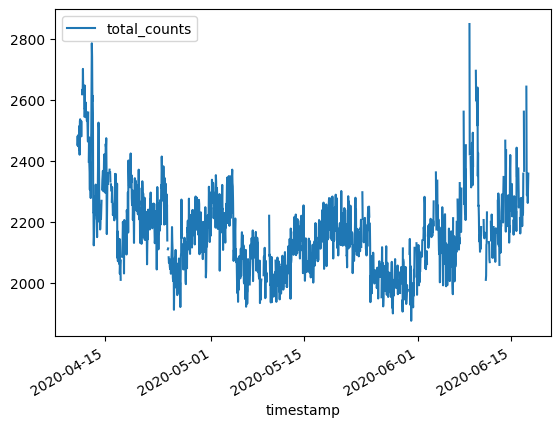

In [5]:
df['total_counts'] = crnpy.compute_total_raw_counts(df[['counts_1','counts_2','counts_3']], nan_strategy='average')
df['total_counts'] = crnpy.drop_outliers(df['total_counts'], min_counts=1500, max_counts=3500, window = 11)
df.plot('timestamp', 'total_counts')


Find similar stations based on cutoff rigidity, which is estimated using latitude and longitude values. See [`get_incoming_neutron_flux()`](../../../reference/#crnpy.crnpy.get_incoming_neutron_flux) and [`find_neutron_detectors()`](../../../reference/#crnpy.crnpy.find_neutron_detectors). Note that the station is hardcoded in the second line as `station="IRKT"`. The user is required to manually define this after considering the potential options suggested.

In [6]:
start_date = df.iloc[0]['timestamp']
end_date = df.iloc[-1]['timestamp']

#Find stations with cutoff rigidity similar to estimated by lat,lon
crnpy.find_neutron_detectors(crnpy.cutoff_rigidity(39.1, -96.6), start_date=start_date, end_date=end_date)

#Download data for one of the similar stations and add to df. Using CST utc offset.
incoming_neutrons = crnpy.get_incoming_neutron_flux(start_date, end_date, station="IRKT", utc_offset=-5)
df['incoming_flux']=crnpy.interpolate_incoming_flux(incoming_neutrons, timestamps=df['timestamp'])



Select a station with an altitude similar to that of your location. For more information go to: 'https://www.nmdb.eu/nest/help.php#helpstations

Your cutoff rigidity is 2.87 GV
     STID     NAME     R  Altitude_m  Period available
13   DRBS  Dourbes  3.18         225              True
40   NEWK   Newark  2.40          50              True
28  KIEL2   KielRT  2.36          54              True
21   IRKT  Irkustk  3.64         435              True


This section is about correcting the atmospheric variables and incoming neutron flux. First, fill the missing values in the atmospheric data, then correct the count for atmospheric variables and incoming flux using [`atm_correction()`](../../../reference/#crnpy.crnpy.atm_correction). 

In [7]:
# Fill NaN values in atmospheric data
df[['pressure', 'RH', 'T']] = crnpy.fill_missing_atm(df[['pressure', 'RH', 'T']])
# Correct count by atmospheric variables and incoming flux
df['total_counts']=crnpy.fill_counts(df['total_counts'], count_times=df['count_time'])
df['corrected']=crnpy.atm_correction(df['total_counts'], pressure=df['pressure'], humidity=df['RH'], temp=df['T'], Pref=df['pressure'].mean(), Aref=0, L=130, incoming_neutrons=df['incoming_flux']).dropna() 


Using median count time as expected count time: 3600.0


C:\Users\jperaza\AppData\Local\anaconda3\envs\crnpy\lib\site-packages\crnpy\crnpy.py:400: UserWarning: Reference incoming neutron flux not provided. Using first value of incoming neutron flux.
  warnings.warn('Reference incoming neutron flux not provided. Using first value of incoming neutron flux.')


Smooth the corrected data using the Savitzky-Golay filter with the [`smooth_1d()`](../../../reference/#crnpy.crnpy.smooth_1d) function.

<Axes: >

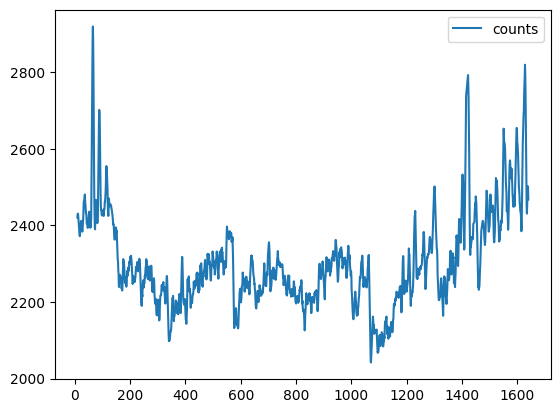

In [8]:
# Filter using the Savitzky-Golay filter
df_filtered = crnpy.smooth_1d(df['corrected'].dropna(), window=11, order=3, method="savitzky_golay")

df_filtered.plot()


Convert the smoothed neutron counts to Volumetric Water Content (VWC) using the [`counts_to_vwc()`](../../../reference/#crnpy.crnpy.counts_to_vwc). The function considers the smoothed neutron counts, $N_0$ specific parameter, soil bulk density, weight percent of latent water (Wlat), and weight percent of soil organic carbon (Wsoc). After conversion, plot the VWC against the timestamp for visual analysis.



<Axes: >

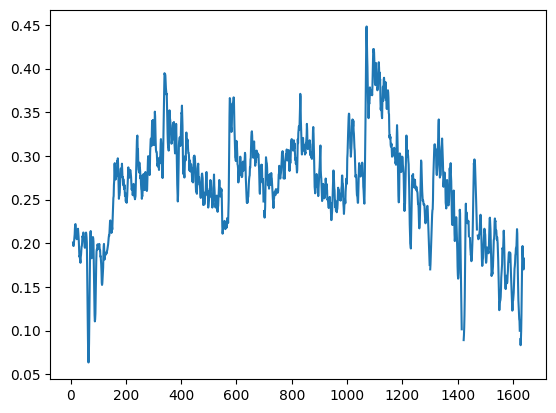

In [9]:
N0_rdt = 3767 # Patrignani, A., Ochsner, T. E., Montag, B., & Bellinger, S. (2021). A novel lithium foil cosmic-ray neutron detector for measuring field-scale soil moisture. Frontiers in Water, 3, 673185.

df['VWC']=crnpy.counts_to_vwc(df_filtered, N0=N0_rdt, bulk_density=1.4, Wlat=0.03, Wsoc=0.01)
df['VWC'].plot()
